In [1]:
#Imports
import numpy as np
import pandas as pd

from utils.graph_utils import *

# Define graph Structure

- define graph and which shift and intercept terms to use


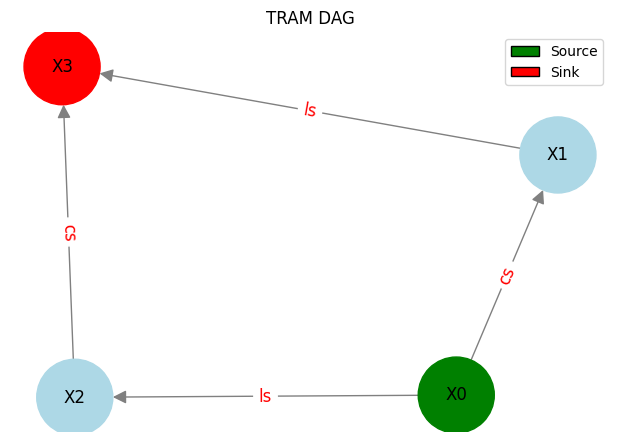

In [2]:
# describe if data is continous or  ordinal  ['cont', 'ord','other']
# note that other data than tabular can only be used as source 



# Example 1 3x3:
# data_type={'X0':'cont','X1':'other','X2':'ord'}  # images, continous, continous, continous
# adj_matrix = np.array([
#     [ "0", "0", "ci"],  # A -> B (cs), A -> C (ls)
#     [ "0", "0", "cs"],  # B -> D (ls)
#     [ "0", "0", "0"],  # C -> D (cs)
# ], object)


## example 2 4x4
data_type={'X0':'other','X1':'ord','X2':'ord','X3':'ord'}  # images, continous, continous, continous    
adj_matrix = np.array([
                                ["0", "cs", "ls", "0"],  # A -> B (cs), A -> C (ls)
                                ["0", "0", "0", "ls"],  # B -> D (ls)
                                ["0", "0", "0", "cs"],  # C -> D (cs)
                                ["0", "0", "0", "0"]    # No outgoing edges from D
                            ], dtype=object)


plot_dag(adj_matrix,data_type, seed=42)

# Configuration for the Models

- all SI and LS model are generated outmatically since these are shallow NN's
- CI and CS have to be defined by the User and can be Passed for each model, -> generate default networks which are generated automaitcally

************* 
 Model has Complex intercepts and Coomplex shifts , please add your Model to the modelzoo 
************


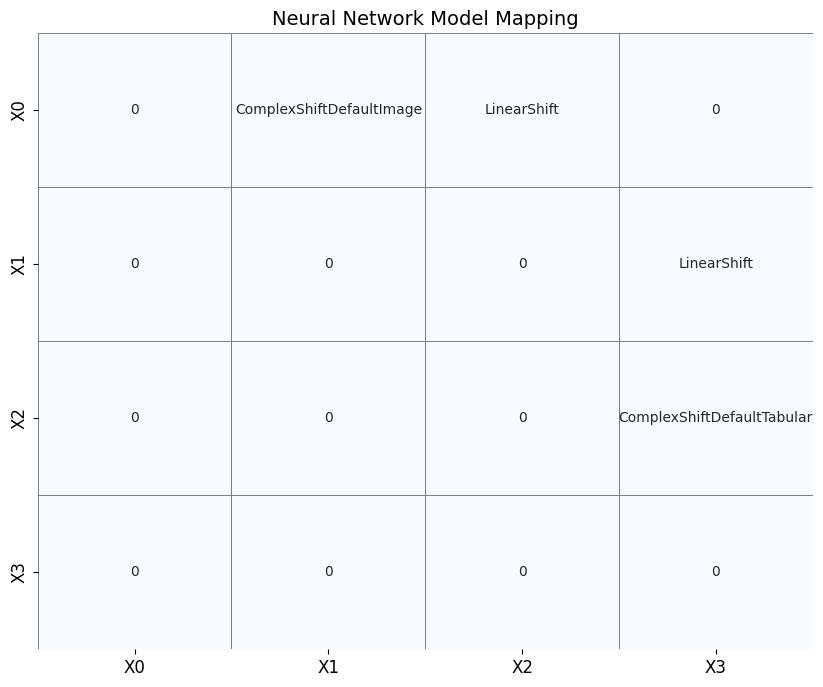

In [ ]:
# check if there are Ci or Compelx shifts in the models. If yes define the modelnames
nn_names_matrix= create_nn_model_names(adj_matrix,data_type)
plot_nn_names_matrix(nn_names_matrix)
## BUG has bug does not find the correct modelnames for the nn image should have x= -X1 should be cS imagedate defalut

In [ ]:
# TODO: fucniton to automate
# if different models should be used, defin model in utils.models 
# e.g ComplexInterceptCUSTOMImage # any possible eg VITS

# rename the modelnames in the nn_names_matrix
# e.g.nn_names_matrix[2,3]='ComplexInterceptCUSTOMImage'  

In [ ]:
configuration_dict=get_configuration_dict(adj_matrix,nn_names_matrix, data_type)
configuration_dict

## Fit models

- each model independently fitting

In [ ]:
# for each model 

- create the ontram model 
 
 - create the dataloaders train val
 
 
 -fit model and save weights..

# Sample